# 实战案例：基于注意力的图像描述模型（ARCTIC）

## 模型训练流程

![模型训练的一般流程](img/cr-traning_process.png)


在现代的深度学习框架基础下，模型训练的一般流程包括读取数据、前馈计算、计算损失、更新参数、选择模型五个步骤。每个步骤需要实现相应的模块。

- 在读取数据阶段，我们首先需要下载数据集，然后对整理数据集的格式，以方便接下来构造数据集类，最后在数据集类的基础上构建能够按批次产生训练、验证和测试数据的对象。

- 在前馈计算阶段，我们需要实现具体的模型，使得模型能够根据输入产生相应的输出。

- 在计算损失阶段，我们需要将模型输出和预期输出进行对比，实现损失函数。

- 在更新参数阶段，我们需要给出具体的参数更新方法，即优化方法；由于现代深度学习框架能够自动计算参数梯度，并实现了绝大多数优化方法，我们通常只需要从中进行选择即可。

- 在选择模型阶段，我们需要实现具体的评估指标，选出在验证集上表现最优的模型参数。

下面，我们将按照这个次序介绍一个图像编码器为CNN网格表示提取器、文本解码器为RNN+注意力的图像描述方法的具体实现。我们的实现大体上是在复现ARCTIC模型，但是在细节上有一些改变，下面的实现过程会对这些改变做具体说明。此外，[链接](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning)给出了一个更接近原始ARCTIC模型的代码库，非常推荐大家阅读。本节的部分代码也是受到该代码库的启发。

## 读取数据

### 下载数据集

- 我们使用的数据集为flickr8k([下载地址](https://www.kaggle.com/adityajn105/flickr8k))。
- 下载解压后，将其图片放在指定目录(本代码中将该目录设置为../data/flickr8k)下的images文件夹里。
- 数据集包括8000张图片，每张图片对应5个句子描述。
- 数据集划分采用Karpathy提供的方法([下载地址](http://cs.stanford.edu/people/karpathy/deepimagesent/caption_datasets.zip))，下载解压后，将其中的dataset_flickr8k.json文件拷贝到指定目录下。该划分方法将数据集分成3个子集：6,000张图片和其对应句子描述组成训练集，1,000张图片和描述为验证集，剩余的1,000张图片和描述为测试集。



### 整理数据集

数据集下载完成后，我们需要对其进行处理，以适合之后构造的PyTorch数据集类读取。
- 对于文本描述，我们首先构建词典，然后根据词典将文本描述转化为向量。
- 对于图像，我们这里仅记录文件路径。
- - 如果机器的内存和硬盘空间就比较大，这里也可以将图片读取并处理成三维数组，这样在模型训练和测试的阶段，就不需要再直接读取图片。

%matplotlib inline
import os
import json
import random 
from collections import defaultdict, Counter
from PIL import Image
from matplotlib import pyplot as plt

def create_dataset(dataset='deepfashion',
                   captions_per_image=5, 
                   min_word_count=5, 
                   max_len=30):
    """
    参数：
        dataset：数据集名称
        captions_per_image：每张图片对应的文本描述数
        min_word_count：仅考虑在数据集中（除测试集外）出现5次的词
        max_len：文本描述包含的最大单词数，如果文本描述超过该值，则截断
    输出：
        一个词典文件： vocab.json
        三个数据集文件： train_data.json、 val_data.json、 test_data.json
    """

    karpathy_json_path='../data/%s/test_captions.json' % dataset  # 训练集的json文件
    image_folder='../data/%s/images' % dataset  # 图片folder
    output_folder='../data/%s' % dataset  # 输出文件夹

    with open(karpathy_json_path, 'r') as j:
        data = json.load(j)  # data是获取的json文件, data是一个字典
    
    image_paths = defaultdict(list)
    image_captions = defaultdict(list)
    vocab = Counter()

    for img in data['images']:
        split = img['split']
        captions = []
        for c in img['sentences']:
            # 更新词频，测试集在训练过程中是未见数据集，不能统计
            if split != 'test':
                vocab.update(c['tokens'])
            # 不统计超过最大长度限制的词
            if len(c['tokens']) <= max_len:
                captions.append(c['tokens'])
        if len(captions) == 0:
            continue

        path = os.path.join(image_folder, img['filename'])
        
        image_paths[split].append(path)
        image_captions[split].append(captions)

    # 创建词典，增加占位标识符<pad>、未登录词标识符<unk>、句子首尾标识符<start>和<end>
    words = [w for w in vocab.keys() if vocab[w] > min_word_count]
    vocab = {k: v + 1 for v, k in enumerate(words)}
    vocab['<pad>'] = 0
    vocab['<unk>'] = len(vocab)
    vocab['<start>'] = len(vocab)
    vocab['<end>'] = len(vocab)

    # 存储词典
    with open(os.path.join(output_folder, 'vocab.json'), 'w') as fw:
        json.dump(vocab, fw)

    # 整理数据集
    for split in image_paths:
        imgpaths = image_paths[split]
        imcaps = image_captions[split]
        
        enc_captions = []

        for i, path in enumerate(imgpaths):
            # 合法性检查，检查图像是否可以被解析
            img = Image.open(path) 
            # 如果该图片对应的描述数量不足，则补足
            if len(imcaps[i]) < captions_per_image:
                captions = imcaps[i] + \
                    [random.choice(imcaps[i]) for _ in range(captions_per_image - len(imcaps[i]))]
            # 如果该图片对应的描述数量超了，则随机采样
            else:
                captions = random.sample(imcaps[i], k=captions_per_image)
            assert len(captions) == captions_per_image
            
            for j, c in enumerate(captions):
                # 对文本描述进行编码
                enc_c = [vocab['<start>']] + [vocab.get(word, vocab['<unk>']) for word in c] + [vocab['<end>']] 
                enc_captions.append(enc_c)
        # 合法性检查
        assert len(imgpaths) * captions_per_image == len(enc_captions)
        
        # 存储数据
        data = {'IMAGES': imgpaths, 
                'CAPTIONS': enc_captions}
        with open(os.path.join(output_folder, split + '_data.json'), 'w') as fw:
            json.dump(data, fw)

create_dataset()

在调用该函数生成需要的格式的数据集文件之后，我们可以展示其中一条数据，简单验证下数据的格式是否和我们预想的一致。

# 读取词典和验证集
with open('../data/flickr8k/vocab.json', 'r') as f:
    vocab = json.load(f)
vocab_idx2word = {idx:word for word,idx in vocab.items()}
with open('../data/flickr8k/val_data.json', 'r') as f:
    data = json.load(f)

# 展示第12张图片，其对应的文本描述序号是60到64
content_img = Image.open(data['IMAGES'][12])
plt.imshow(content_img)
for i in range(5):
    print(' '.join([vocab_idx2word[word_idx] for word_idx in data['CAPTIONS'][12*5+i]]))


### 定义数据集类

在准备好的数据集的基础上，我们需要进一步定义PyTorch Dataset类，以使用PyTorch DataLoader类按批次产生数据。PyTorch中仅预先定义了图像、文本和语音的单模态任务中常见的数据集类。因此，我们需要定义自己的数据集类。

在PyTorch中定义数据集类非常简单，仅需要继承torch.utils.data.Dataset类，并实现\_\_getitem\_\_和\_\_len\_\_两个函数即可。

In [1]:
%matplotlib inline
import os
import json
import random 
from collections import defaultdict, Counter
import re
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
def create_dataset(dataset='deepfashion',
                   captions_per_image=1, 
                   min_word_count=3, 
                   max_len=100):
    """
    参数：
        dataset：数据集名称
        captions_per_image：每张图片对应的文本描述数
        min_word_count：仅考虑在数据集中（除测试集外）出现5次的词
        max_len：文本描述包含的最大单词数，如果文本描述超过该值，则截断
    输出：
        一个词典文件： vocab.json
        三个数据集文件： train_data.json、 val_data.json、 test_data.json
    """

    karpathy_json_path='../data/%s/train_captions.json' % dataset  # 训练集的json文件
    image_folder='../data/%s/images' % dataset  # 图片folder
    output_folder='../data/%s/' % dataset  # 输出文件夹

    with open(karpathy_json_path, 'r') as j:
        data = json.load(j)  # data是获取的json文件,data是一个字典！！！！！！！！
    
    image_paths = defaultdict(list)  # 图片路径
    image_captions = defaultdict(list)  # 图片标注
    vocab = Counter()  # 每个词语出现的次数

    # 假设data是你的数据集字典
    train_keys, val_keys = train_test_split(list(data.keys()), test_size=0.1, random_state=42)
    for img in data.keys():
        captions = []
        sentences = data[f'{img}']  # 1个句子
        words = re.findall(r"[\w'-]+|[.,!?;]", sentences)  # 将文本分割成单词和标点符号
        vocab.update(words)
        if len(words) <= max_len:
            captions.append(words)
        path = os.path.join(image_folder, img)

        if img in train_keys:
            image_paths['train'].append(path)
            image_captions['train'].append(captions)
        else:
            image_paths['val'].append(path)
            image_captions['val'].append(captions)

    karpathy_json_path_t='../data/%s/test_captions.json' % dataset  # 训练集的json文件
    with open(karpathy_json_path_t, 'r') as j:
        data = json.load(j)  # data是获取的json文件,data是一个字典！！！！！！！！
    for img in data.keys():
        captions = []
        sentences = data[f'{img}']  # 5个句子
        words = re.findall(r"[\w'-]+|[.,!?;]", sentences)
        if len(words) <= max_len:
                captions.append(words)
        path = os.path.join(image_folder, img)
        
        image_paths['test'].append(path)
        image_captions['test'].append(captions)
        
    # 创建词典，增加占位标识符<pad>、未登录词标识符<unk>、句子首尾标识符<start>和<end>
    words = [w for w in vocab.keys() if vocab[w] > min_word_count]
    vocab = {k: v + 1 for v, k in enumerate(words)}
    vocab['<pad>'] = 0
    vocab['<unk>'] = len(vocab)
    vocab['<start>'] = len(vocab)
    vocab['<end>'] = len(vocab)

# 储存词典
    try:
        with open(os.path.join(output_folder, 'vocab.json'), 'w') as fw:
            json.dump(vocab, fw)
        print("Writing to 'vocab.json' successful!")
    except Exception as e:
        print("An error occurred while writing to 'vocab.json':", e)

    # 整理数据集
    for split in image_paths:
        # print(split)
        imgpaths = image_paths[split]  # 图片加载
        imcaps = image_captions[split]
        print(imcaps)
        enc_captions = []

        for i, path in enumerate(imgpaths):
            # 合法性检查，检查图像是否可以被解析
            img = Image.open(path) 
            # 如果该图片对应的描述数量不足，则补足
            if len(imcaps[i]) < captions_per_image:
                captions = imcaps[i] + [''] * (captions_per_image - len(imcaps[i]))
            # 如果该图片对应的描述数量超了，则随机采样
            else:
                captions = random.sample(imcaps[i], k=captions_per_image)
            assert len(captions) == captions_per_image
            
            for j, c in enumerate(captions):
                # 对文本描述进行编码
                enc_c = [vocab['<start>']] + [vocab.get(word, vocab['<unk>']) for word in c] + [vocab['<end>']] 
                enc_captions.append(enc_c)
        # 合法性检查
        assert len(imgpaths) * captions_per_image == len(enc_captions)
        
        # 存储数据
        data = {'IMAGES': imgpaths, 
                'CAPTIONS': enc_captions}
        with open(os.path.join(output_folder, split + '_data.json'), 'w') as fw:
            json.dump(data, fw)


#         for c in sentence:  # c是一个句子
#             words = c.split()
#             vocab.update(words)
#             # print(vocab)
#             if len(words) <= max_len:
#                 captions.append(words)
#                 # print(captions)
#         if len(captions)==0:
#             continue
        
#         path = os.path.join(image_folder, img)
        
#         if img in train_keys:
#             image_paths['train'].append(path)
#             image_captions['train'].append(captions)
#         else:
#             image_paths['val'].append(path)
#             image_captions['val'].append(captions)
#     # print(image_paths['valid'])
    
#     # 测试集
#     karpathy_json_path_t='../data/%s/test_captions.json' % dataset  # 训练集的json文件
#     with open(karpathy_json_path_t, 'r') as j:
#         data = json.load(j)  # data是获取的json文件,data是一个字典！！！！！！！！
#     for img in data.keys():
#         captions = []
#         sentences = data[f'{img}']  # 5个句子
#         sentence = sentences.split('.')  # sentence 就是索引
#         for c in sentence:  # c是一个句子
#             words = c.split()
#             if len(words) <= max_len:
#                 captions.append(words)
#         if len(captions)==0:
#             continue
#         path = os.path.join(image_folder, img)
#         image_paths['test'].append(path)
#         image_captions['test'].append(captions)
#     # print(image_paths['test'])
    
#     # 创建词典，增加占位标识符<pad>、未登录词标识符<unk>、句子首尾标识符<start>和<end>
#     words = [w for w in vocab.keys() if vocab[w] > min_word_count]
#     vocab = {k: v + 1 for v, k in enumerate(words)}
#     vocab['<pad>'] = 0
#     vocab['<unk>'] = len(vocab)
#     vocab['<start>'] = len(vocab)
#     vocab['<end>'] = len(vocab)
#     print(vocab)
#     print(output_folder)
#     # 存储词典
#     try:
#         with open(os.path.join(output_folder, 'vocab.json'), 'w') as fw:
#             json.dump(vocab, fw)
#         print("Writing to 'vocab.json' successful!")
#     except Exception as e:
#         print("An error occurred while writing to 'vocab.json':", e)

#     # 整理数据集
#     for split in image_paths:
#         print(split)
#         imgpaths = image_paths[split]  # 图片加载
#         imcaps = image_captions[split]
        
#         enc_captions = []

#         for i, path in enumerate(imgpaths):
#             # 合法性检查，检查图像是否可以被解析
#             img = Image.open(path) 
#             # 如果该图片对应的描述数量不足，则补足
#             if len(imcaps[i]) < captions_per_image:
#                 captions = imcaps[i] + \
#                     [random.choice(imcaps[i]) for _ in range(captions_per_image - len(imcaps[i]))]
#             # 如果该图片对应的描述数量超了，则随机采样
#             else:
#                 captions = random.sample(imcaps[i], k=captions_per_image)
#             assert len(captions) == captions_per_image
            
#             for j, c in enumerate(captions):
#                 # 对文本描述进行编码
#                 enc_c = [vocab['<start>']] + [vocab.get(word, vocab['<unk>']) for word in c] + [vocab['<end>']] 
#                 enc_captions.append(enc_c)
#         # 合法性检查
#         assert len(imgpaths) * captions_per_image == len(enc_captions)
        
#         # 存储数据
#         data = {'IMAGES': imgpaths, 
#                 'CAPTIONS': enc_captions}
#         with open(os.path.join(output_folder, split + '_data.json'), 'w') as fw:
#             json.dump(data, fw)

# create_dataset()

In [35]:
import json
def generated_sentences(data):
    # 读取词典和验证集
    with open('../data/deepfashion/vocab.json', 'r') as f:
        vocab = json.load(f)
    vocab_idx2word = {idx:word for word,idx in vocab.items()}
    for i, text in enumerate(data):
        print(' '.join([vocab_idx2word[word_idx] for word_idx in text]))


In [36]:
data = [[112, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 61, 12, 13, 14, 45, 4, 33, 19, 15, 14, 1, 20, 3, 18, 16, 5, 21, 14, 1, 9, 18, 8, 10, 17, 4, 11, 12, 13, 14, 1, 28, 3, 18, 29, 8, 9, 10, 30, 13, 14, 23, 51, 26, 33, 34, 14, 113], [112, 1, 47, 18, 32, 33, 101, 41, 29, 96, 13, 14, 1, 41, 18, 29, 8, 9, 14, 45, 4, 33, 71, 15, 14, 1, 48, 59, 47, 26, 18, 16, 5, 21, 14, 1, 48, 49, 29, 22, 9, 10, 11, 12, 13, 14, 23, 51, 18, 32, 33, 34, 35, 36, 37, 14, 113], [112, 1, 24, 18, 32, 33, 72, 41, 29, 61, 12, 13, 14, 1, 41, 18, 29, 43, 9, 10, 67, 15, 18, 46, 14, 1, 24, 26, 33, 60, 74, 14, 1, 74, 49, 29, 22, 9, 10, 61, 12, 13, 14, 53, 18, 33, 34, 35, 36, 37, 14, 113], [112, 1, 73, 80, 31, 26, 4, 76, 6, 10, 17, 18, 29, 8, 9, 10, 44, 13, 14, 1, 15, 16, 59, 73, 18, 75, 14, 23, 31, 26, 33, 60, 74, 7, 29, 8, 9, 10, 11, 12, 13, 14, 53, 18, 27, 55, 35, 36, 56, 14, 23, 31, 18, 32, 33, 34, 35, 36, 37, 14, 113], [112, 1, 40, 41, 80, 47, 26, 4, 42, 6, 7, 67, 9, 18, 8, 7, 10, 17, 4, 44, 13, 14, 1, 40, 41, 4, 33, 75, 15, 14, 23, 47, 26, 33, 60, 74, 7, 29, 22, 9, 10, 61, 12, 13, 14, 53, 18, 27, 55, 62, 63, 36, 64, 14, 53, 18, 33, 34, 35, 36, 37, 14, 53, 18, 27, 55, 35, 36, 56, 14, 113]]
generated_sentences(data)

<start> The upper clothing has long sleeves , cotton fabric and pure color patterns . It has a v-shape neckline . The lower clothing is of long length . The fabric is cotton and it has solid color patterns . The outer clothing is with cotton fabric and complicated patterns . This woman wears a ring . <end>
<start> The person is wearing a medium-sleeve shirt with striped patterns . The shirt is with cotton fabric . It has a suspenders neckline . The pants the person wears is of long length . The pants are with denim fabric and solid color patterns . This woman is wearing a ring on her finger . <end>
<start> The lady is wearing a short-sleeve shirt with pure color patterns . The shirt is with chiffon fabric and its neckline is round . The lady wears a three-point shorts . The shorts are with denim fabric and pure color patterns . There is a ring on her finger . <end>
<start> The T-shirt this female wears has short sleeves and it is with cotton fabric and graphic patterns . The neckline o

In [32]:
import json

def generated_sentences(data):
    # 读取词典和验证集
    with open('../data/deepfashion/vocab.json', 'r') as f:
        vocab = json.load(f)
    vocab_idx2word = {idx: word for word, idx in vocab.items()}
    
    result = []  # 存储结果
    for idx in data:
        if idx in vocab_idx2word:
            result.append(vocab_idx2word[idx])
    
    return result


In [28]:
import json

def generated_str(data):
    # 读取词典和验证集
    with open('../data/deepfashion/vocab.json', 'r') as f:
        vocab = json.load(f)
    vocab_idx2word = {idx: word for word, idx in vocab.items()}
    
    result = []  # 存储结果
    for inner_list in data:
        inner_result = []  # 存储内部列表的结果
        for idx in inner_list:
            if idx in vocab_idx2word:
                inner_result.append(vocab_idx2word[idx])
        result.append(inner_result)
    
    return result


In [30]:
result = generated_str([[1, 2, 3, 4, 5]])
print(result)

[['The', 'upper', 'clothing', 'has', 'long']]


<start> This female is wearing a short-sleeve shirt with graphic patterns and a long trousers . The shirt is with cotton fabric . The neckline of the shirt is lapel . The trousers are with cotton fabric and pure color patterns . There is an accessory on her wrist . The person is wearing a ring on her finger . There is an accessory in his her neck . <end>
(750, 1101)


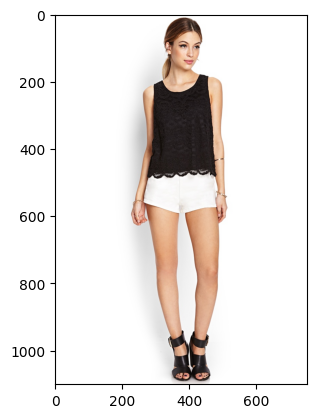

In [63]:
# 读取词典和验证集
with open('../data/deepfashion/vocab.json', 'r') as f:
    vocab = json.load(f)
vocab_idx2word = {idx:word for word,idx in vocab.items()}
with open('../data/deepfashion/val_data.json', 'r') as f:
    data = json.load(f)

# 展示第12张图片，其对应的文本描述序号是60到64
content_img = Image.open(data['IMAGES'][3])
plt.imshow(content_img)

print(' '.join([vocab_idx2word[word_idx] for word_idx in data['CAPTIONS'][16]]))
print(content_img.size)

In [64]:
from argparse import Namespace 
import numpy as np
import os
import json
from PIL import Image
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

class ImageTextDataset(Dataset):
    """
    PyTorch数据类，用于PyTorch DataLoader来按批次产生数据
    """

    def __init__(self, dataset_path, vocab_path, split, captions_per_image=1, max_len=70, transform=None):
        """
        参数：
            dataset_path：json格式数据文件路径
            vocab_path：json格式词典文件路径
            split：train、val、test
            captions_per_image：每张图片对应的文本描述数
            max_len：文本描述包含的最大单词数
            transform: 图像预处理方法
        """
        self.split = split
        assert self.split in {'train', 'val', 'test'}
        self.cpi = captions_per_image
        self.max_len = max_len

        # 载入数据集
        with open(dataset_path, 'r') as f:
            self.data = json.load(f)
        # 载入词典
        with open(vocab_path, 'r') as f:
            self.vocab = json.load(f)

        # PyTorch图像预处理流程
        self.transform = transform

        # Total number of datapoints
        self.dataset_size = len(self.data['CAPTIONS'])

    def __getitem__(self, i):
        # 第i个文本描述对应第(i // captions_per_image)张图片
        img = Image.open(self.data['IMAGES'][i // self.cpi]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        caplen = len(self.data['CAPTIONS'][i])
        caption = torch.LongTensor(self.data['CAPTIONS'][i]+ [self.vocab['<pad>']] * (self.max_len + 2 - caplen))
        
        return img, caption, caplen
        

    def __len__(self):
        return self.dataset_size

### 批量读取数据

利用刚才构造的数据集类，借助DataLoader类构建能够按批次产生训练、验证和测试数据的对象。

In [65]:
def mktrainval(data_dir, vocab_path, batch_size, workers=4):
    """
    data_dir: 数据集文件夹
    vocab_path: 词典文件路径
    batch_size: 批次大小
    workers: 多线程加载数据的线程数
    """
    train_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    train_set = ImageTextDataset(os.path.join(data_dir, 'train_data.json'), 
                                 vocab_path, 'train',  transform=train_tx)
    valid_set = ImageTextDataset(os.path.join(data_dir, 'val_data.json'), 
                                 vocab_path, 'val', transform=val_tx)
    test_set = ImageTextDataset(os.path.join(data_dir, 'test_data.json'), 
                                 vocab_path, 'test', transform=val_tx)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    valid_loader = torch.utils.data.DataLoader(
        valid_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)
    
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)

    return train_loader, valid_loader, test_loader    


In [66]:
train_loader, valid_loader, test_loader   = mktrainval('../data/deepfashion', '../data/deepfashion/vocab.json', 4, 4)
for i, (img, caption, caplen) in enumerate(train_loader):
    print(img.shape)
    print(caption)
    print(caplen.shape)
    break

torch.Size([4, 3, 224, 224])
tensor([[112,   1,   2,   3,   4,  42,   6,   7,   8,   9,  10,  11,  12,  13,
          14,   1,  15,  16,  17,  18,  75,  14,   1,  20,   3,  18,  16,   5,
          21,  14,   1,   9,  18,   8,  10,  17,   4,  44,  13,  14,  53,  18,
          27,  55,  35,  36,  56,  14,   1,  31,  18,  32,  33,  34,  35,  36,
          37,  14,  53,  18,  27,  55,  62,  63,  36,  64,  14, 113,   0,   0,
           0,   0],
        [112,   1,  40,  41,  80,  31,  26,   4,   6,  87,  88,  10,  67,   9,
          18,   8,  14,   1,  86,  16,  17,  18,  11,  12,  14,  45,   4,  33,
          71,  15,  14,  23,  31,  26,  33,  60,  95,   7,  29,   8,   9,  10,
          11,  12,  13,  14,  53,  18,  27,  55,  35,  36,  56,  14, 113,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [112,   1,  57,  80,  47,  26,   4,   5,   6,   7,  67,   9,  18,  90,
           7,  10,  17,   4,  11,  12,  13,  14,   1,  57,   4

## 定义模型

ARCTIC模型是一个典型的基于注意力的编解码模型，其编码器为图像网格表示提取器，解码器为循环神经网络。解码器在每生成一个词时，都利用注意力机制考虑当前生成的词和图像中的哪些网格更相关。

![ARCTIC的模型结构示意图](img/mt-cnn-attn.png)


### 图像编码器

ARCTIC原始模型使用在ImageNet数据集上预训练过的分类模型VGG19作为图像编码器，VGG19最后一个卷积层作为网格表示提取层。而我们这里使用ResNet-101作为图像编码器，并将其最后一个非全连接层作为网格表示提取层。

In [8]:
from torchvision.models import ResNet101_Weights
class ImageEncoder(nn.Module):
    def __init__(self, finetuned=True):
        super(ImageEncoder, self).__init__()
        model = torchvision.models.resnet101(weights=ResNet101_Weights.DEFAULT)
        # ResNet-101网格表示提取器
        self.grid_rep_extractor = nn.Sequential(*(list(model.children())[:-2]))
        for param in self.grid_rep_extractor.parameters():
            param.requires_grad = finetuned
        
    def forward(self, images):
        out = self.grid_rep_extractor(images)   # 提取的是图片特征一堆数字
        return out

In [9]:
v = ImageEncoder()
img = torch.randn(1, 3, 512, 512)

preds = v(img) # (1, 1000)
print(preds.shape)

torch.Size([1, 2048, 16, 16])


In [10]:
import torch
from torch import nn
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        """
        image_size: 图片大小
        patch_size: 分块大小
        num_classes: 分类数
        dim: 每个分块的维度
        depth: 深度
        heads: 多头注意力的头数
        mlp_dim: MLP的维度
        pool: 池化方式
        channels: 通道数
        dim_head: 头的维度
        dropout: dropout率
        emb_dropout: 嵌入层的dropout率
        """
        super().__init__()

        # 返回一个元组，图片大小分块大小
        image_height, image_width = pair(image_size)  # 图片大小 224*224
        patch_height, patch_width = pair(patch_size)  # 分块大小 16*16

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'  # 判断必须可分

        num_patches = (image_height // patch_height) * (image_width // patch_width)  # 计算个数
        patch_dim = channels * patch_height * patch_width  # 每一块多少维 3*16*16
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),  # 图分割 N 14*14 16*16*3
            nn.LayerNorm(patch_dim),  # 层正则化
            nn.Linear(patch_dim, dim), # 映射 16*16*3 到 
            nn.LayerNorm(dim),  # 层正则化
        )  # 分块

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)
        self.to_512 = nn.Linear(num_patches + 1, 512)
    def forward(self, img):
        x = self.to_patch_embedding(img)
        # print(x.shape)
        b, n, _ = x.shape  # b is batch_size, n is the number of image patches
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)
        x = x.transpose(1,2)
        x = self.to_512(x)
        x = x.transpose(1,2)
        # print(x.shape)
        # x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]

        # x_resized = F.interpolate(x.unsqueeze(0), size=(512, 1024), mode='bilinear', align_corners=False)

        # x = self.to_latent(x)
        # return self.mlp_head(x)
        return x

In [11]:
# 视觉Transformer作为图像编码器
v = ViT(
    image_size = 224,
    patch_size = 16,
    num_classes = 1000,
    dim = 1024,
    depth = 8,
    heads = 8,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)
img = torch.randn(1, 3, 224, 224)
preds = v(img) # (1, 257, 1024)
print(preds)

tensor([[[ 0.5099,  0.3826,  0.1037,  ...,  0.1582,  0.2710, -0.2528],
         [ 0.3272, -0.4506, -0.1825,  ...,  0.0987, -0.1653, -0.5722],
         [-0.1642,  0.1276,  0.9757,  ...,  0.2729, -0.8012, -0.6368],
         ...,
         [-0.4331, -0.4967,  0.6419,  ...,  0.4726, -0.4635, -0.0268],
         [ 0.7185, -1.0780, -0.3117,  ..., -0.3616, -0.6201,  1.0325],
         [ 0.3129,  0.5149,  0.1772,  ...,  0.7647,  0.4680,  0.0912]]],
       grad_fn=<TransposeBackward0>)


### 文本解码器

ARCTIC原始模型使用结合注意力的LSTM作为文本解码器，我们这里使用结合注意力的GRU作为文本解码器，注意力评分函数采用的是加性注意力。下面给出加性注意力和解码器的具体实现。


加性注意力评分函数的具体形式为 $W_2^T{\rm tanh}(W_1 [\mathbf{q}_i; \mathbf{k}_j])$ 。

- 首先将权重 $W_1$ 依照查询q和键k的维度，相应地拆成两组权重，分别将单个查询和一组键映射到到注意力函数隐藏层表示空间；
- 然后将二者相加得到一组维度为attn_dim的表示，并在经过非线性变换后，使用形状为(attn_dim, 1) 的权重 $W_2$ 将其映射为一组数值；
- 再通过softmax函数获取单个查询和所有键的关联程度，即归一化的相关性分数；
- 最后以相关性得分为权重，对值进行加权求和，计算输出特征。这里的值和键是同一组向量表示。

In [12]:
class AdditiveAttention(nn.Module):
    def  __init__(self, query_dim, key_dim, attn_dim):
        """
        参数：
            query_dim: 查询Q的维度
            key_dim: 键K的维度
            attn_dim: 注意力函数隐藏层表示的维度
        """
        super(AdditiveAttention, self).__init__()
        self.attn_w_1_q = nn.Linear(query_dim, attn_dim)
        self.attn_w_1_k = nn.Linear(key_dim, attn_dim)
        self.attn_w_2 = nn.Linear(attn_dim, 1)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, query, key_value):
        """
        Q K V：Q和K算出相关性得分，作为V的权重，K=V
        参数：
            query: 查询 (batch_size, q_dim)
            key_value: 键和值，(batch_size, n_kv, kv_dim)
        """
        # （2）计算query和key的相关性，实现注意力评分函数
        # -> (batch_size, 1, attn_dim)
        queries = self.attn_w_1_q(query).unsqueeze(1)
        # -> (batch_size, n_kv, attn_dim)
        keys = self.attn_w_1_k(key_value)
        # -> (batch_size, n_kv)
        attn = self.attn_w_2(self.tanh(queries+keys)).squeeze(2) 
        # （3）归一化相关性分数
        # -> (batch_size, n_kv)
        attn = self.softmax(attn) 
        # （4）计算输出
        # (batch_size x 1 x n_kv)(batch_size x n_kv x kv_dim)
        # -> (batch_size, 1, kv_dim)
        output = torch.bmm(attn.unsqueeze(1), key_value).squeeze(1)
        return output, attn

解码器前馈过程的实现流程如下：

（1）将图文数据按照文本的实际长度从长到短排序，这是为了模拟pack_padded_sequence函数的思想，方便后面使用动态的批大小，以避免<pad>参与运算带来的非必要的计算消耗。

![pack_padded_sequence函数的作用的示例图](img/cr-pack_padded_sequence-example.png)
    

（2）在第一时刻解码前，使用图像表示来初始化GRU的隐状态。

（3）解码的每一时刻的具体操作可以分解为如下4个子操作：
    
- （3.1）获取实际的批大小；

- （3.2）利用GRU前一时刻最后一个隐藏层的状态作为查询，图像表示作为键和值，获取上下文向量；

- （3.3）将上下文向量和当前时刻输入的词表示拼接起来，作为GRU该时刻的输入，获得输出；

- （3.4）使用全连接层和softmax激活函数将GRU的输出映射为词表上的概率分布。

In [13]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=512):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term2 = torch.pow(torch.tensor(10000000.0), torch.arange(0, d_model, 2).float() / d_model)
        div_term1 = torch.pow(torch.tensor(10000000.0), torch.arange(1, d_model, 2).float() / d_model)
        pe[:, 0::2] = torch.sin(position * div_term2)
        pe[:, 1::2] = torch.cos(position * div_term1)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, word_dim, num_layers, num_heads, mlp_dim, dropout=0.1):
        """
        vocab_size: 词汇表大小
        word_dim: 词嵌入维度
        num_layers: 解码器层数
        num heads: 多头注意力的头数
        mlp_dim: MLP的维度
        dropout: dropout率
        """
        super(TransformerDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.embed = nn.Embedding(vocab_size, word_dim)
        self.pos_embedding = nn.Embedding(vocab_size, word_dim)  # positional embedding
        self.positional_encoding = PositionalEncoding(word_dim)
        self.decoder_layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model=word_dim, nhead=num_heads, dim_feedforward=mlp_dim, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.fc = nn.Linear(word_dim, vocab_size)
        self.dropout = nn.Dropout(p=dropout)
        self.init_weights()

    def init_weights(self):
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, image_features, captions, lengths):
        batch_size, image_code_dim = image_features.size(0), image_features.size(2)
        # -> (batch_size, grid_height*grid_width+1, image_code_dim) 
        # （1）按照caption的长短排序
        sorted_cap_lens, sorted_cap_indices = torch.sort(lengths, 0, True)
        captions = captions[sorted_cap_indices]
        image_code = image_code[sorted_cap_indices]
        return image_code, captions, sorted_cap_lens, sorted_cap_indices
    
    def forward_step(self, image_features, captions_emb, lengths, step):
        """
        image_features: 图像特征 (batch_size, patch_num+1, dim)
        captions: 当前生成的部分标注序列 (batch_size, current_length)
        lengths: 标注序列的实际长度 (batch_size, )
        step: 当前解码的步骤
        """
        # 与 forward 方法类似，但只处理当前步骤的信息
        cap_embeds = captions_emb[:, :step]  # 使用传入的嵌入表示
        # cap_embeds = self.positional_encoding(cap_embeds)

        mask = nn.Transformer.generate_square_subsequent_mask(cap_embeds.size(1)).to(cap_embeds.device)
        
        output = cap_embeds.transpose(0, 1)
        memory = image_features.transpose(0, 1)
        for i in range(len(self.decoder_layers)):
            output = self.decoder_layers[i](output, memory, mask)
        
        output = output[-1, :, :]
        output = self.fc(self.dropout(output))
        return output
    
    def forward(self, image_features, captions, lengths):
        
        # 同样是将图文数据按照文本的实际长度从长到短排序
        # image_features,captions,sorted_cap_lens, sorted_cap_indices = self.init_hidden_state(image_features, captions, lengths)
        # batch_size = image_features.size(0)
        # lengths = sorted_cap_lens.cpu().numpy() - 1
        # # 初始化变量：模型的预测结果和注意力分数
        # predictions = torch.zeros(batch_size, lengths[0], self.fc.out_features).to(captions.device)
        # image_features: (batch_size, patch_num    ,dim)
        # captions: (batch_size, num_steps) 图片标注
        # lengths: (batch_size, ) 图片标注的长度
        cap_embeds = self.embed(captions) # (batch_size, num_steps, word_dim) num_steps是caption的长度,就是有多少单词,编码
        # print(cap_embeds)
        # cap_embeds = self.positional_encoding(cap_embeds)
        # print(f'cap_embeds{cap_embeds.shape}')
        # for step in range(lengths[0]):
            
        mask = nn.Transformer.generate_square_subsequent_mask(cap_embeds.size(1)).to(captions.device)  # 对角掩码
        # print(f'mask{mask}')
        output = cap_embeds.transpose(0,1)
        memory = image_features.transpose(0,1)
        for layer in self.decoder_layers:
            # print(f'output{output.shape}')
            # print(f'mask{mask.shape}')
            # print(f'memory{memory.shape}')
            output = layer(output, memory, mask)  # Use image_features as memory
        output = output.transpose(0, 1)
        softmax_predictions = torch.softmax(output, dim=-1)
        _, predicted_indices = torch.max(softmax_predictions, dim=-1)
        # print(predicted_indices)
        predictions = self.fc(self.dropout(output))  # [1,5,123] 5个预测，每个123个维度
        # print(f'predictions{predictions.shape}')
        return predictions[:, :-1, :], captions[:, 1:], lengths - 1  # 不要最后一个


# Create a TransformerDecoder instance
with open('../data/deepfashion/vocab.json', 'r') as f:
    vocab = json.load(f)
decoder = TransformerDecoder(vocab_size=len(vocab), word_dim=512,  num_layers=1, num_heads=8,mlp_dim=2048, dropout=0.0)

v = ViT(
    image_size = 224,
    patch_size = 16,
    num_classes = 1000,
    dim = 512,
    depth = 8,
    heads = 8,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

# 测试
img = torch.randn(2, 3, 224, 224)  
image_features = v(img)
print(f'image_features{image_features.shape}')
captions = torch.tensor([[1,2,3,4,5,6,7,8,9],[9,8,7,6,5,4,3,2,1]])# Assume there are two samples, each with 5 words
print(captions.shape)
lengths = torch.tensor([9,8])  # Actual lengths of each sample is 5

# Perform forward propagation
predictions, targets, lengths = decoder(image_features, captions, lengths)
softmax_predictions = torch.softmax(predictions, dim=-1)
_, predicted_indices = torch.max(softmax_predictions, dim=-1)
predicted_indices_list = predicted_indices.tolist()
print(predicted_indices_list)
generated_sentences(predicted_indices_list)
# Print the results
print("Predictions:")
print(predictions.shape)
print("Targets:")
print(targets)
print("Lengths:")
print(lengths)


image_featurestorch.Size([2, 512, 512])
torch.Size([2, 9])
[[52, 62, 33, 76, 5, 1, 95, 97], [84, 97, 13, 20, 39, 76, 33, 62]]
There his ring sleeveless long The gentleman mixed
trousers, mixed neckline denim tank sleeveless ring his
Predictions:
torch.Size([2, 8, 123])
Targets:
tensor([[2, 3, 4, 5, 6, 7, 8, 9],
        [8, 7, 6, 5, 4, 3, 2, 1]])
Lengths:
tensor([8, 7])


In [14]:
# decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8, batch_first=True)
# img = torch.randn(2, 3, 224, 224)  
# image_features = v(img)
# memory = torch.rand(2, 10, 512)
# tgt = torch.rand(2, 20, 512)
# mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(1)).to(captions.device)  # 对角掩码
# predictions = decoder_layer(tgt, image_features,mask)
# softmax_predictions = torch.softmax(predictions, dim=-1)
# _, predicted_indices = torch.max(softmax_predictions, dim=-1)
# print(predicted_indices)


In [15]:
vocab_size = 5
decoder = TransformerDecoder(vocab_size=vocab_size, word_dim=512, num_layers=6, num_heads=8, mlp_dim=2048, dropout=0.1)

# 创建一个简单的模拟数据
batch_size = 2
max_seq_length = 3
word_dim = 512

image_features = torch.randn(batch_size, 10, word_dim)  # (batch_size, num_patches+1, word_dim)
captions = torch.randint(1, vocab_size, (batch_size, max_seq_length))  # (batch_size, max_seq_length)
lengths = torch.randint(2, max_seq_length, (batch_size,))  # (batch_size,)
print(captions.shape)
# 将captions嵌入
captions_emb = decoder.embed(captions)
print(image_features.shape,captions_emb.shape,lengths.shape)
# 进行前向传播
predictions = []
for i in range(max_seq_length - 1):  # 逐步预测每个词
    output = decoder.forward_step(image_features, captions_emb, lengths, i+1)  # 第i+1步的预测

    predictions.append(output.unsqueeze(1))  # 将每步的预测添加到列表中

predictions = torch.cat(predictions, dim=1)  # (batch_size, max_seq_length-1, vocab_size)
print("Predictions shape:", predictions)


torch.Size([2, 3])
torch.Size([2, 10, 512]) torch.Size([2, 3, 512]) torch.Size([2])
Predictions shape: tensor([[[ 0.2157, -0.5912,  0.8828,  0.3853, -1.3461],
         [ 0.0052,  0.5477,  0.8303, -0.7688, -0.0792]],

        [[ 0.5313, -1.8097, -0.3040,  0.7992, -1.5627],
         [ 1.9759, -1.1722, -0.4999,  1.1196, -1.0108]]],
       grad_fn=<CatBackward0>)


### ARCTIC模型

在定义编码器和解码器完成之后，我们就很容易构建图像描述模型ARCTIC了。仅需要在初始化函数时声明编码器和解码器，然后在前馈函数实现里，将编码器的输出和文本描述作为解码器的输入即可。

这里我们额外定义了束搜索采样函数，用于生成句子，以计算BLEU值。下面的代码详细标注了其具体实现。

In [16]:
import torch
class VitTransformerDecoder(nn.Module):
    def __init__(self, image_code_dim, vocab, word_dim, num_layers):
        super(VitTransformerDecoder, self).__init__()
        self.vocab = vocab
        self.encoder = ViT(
                image_size=224,
                patch_size=16,
                num_classes=1000,
                dim=image_code_dim,
                depth=num_layers,
                heads=4,
                mlp_dim=2048,
                dropout=0.0,
                emb_dropout=0.0
            )
        self.decoder = TransformerDecoder(
            vocab_size=len(vocab),
            word_dim=word_dim,
            num_layers=num_layers,
            num_heads=4,
            mlp_dim=2048,
            dropout=0.0
        )

    def forward(self, image, captions, lengths):
        """
        image: (batch_size, 3, 224, 224)
        captions: (batch_size, num_steps) 图片标注
        lengths: (batch_size, ) 图片标注的长度
        """
        image_features = self.encoder(image)
        predictions, targets, lengths = self.decoder(image_features, captions, lengths)
        return predictions, targets, lengths
    
    # 束搜索
    def generate_by_beamsearch(self, images, beam_k, max_len):
        vocab_size = len(self.vocab)
        image_codes = self.encoder(images)  # 图片特征
        # print(f'image_codes{image_codes.shape}')  #([2, 512, 1024])
        texts = []
        device = images.device
        # 对每个图像样本执行束搜索
        for image_code in image_codes:  # 对于每张图片
            # 将图像表示复制k份
            image_code = image_code.unsqueeze(0).repeat(beam_k,1,1,1)
            # 生成k个候选句子，初始时，仅包含开始符号<start>
            cur_sents = torch.full((beam_k, 1), self.vocab['<start>'], dtype=torch.long).to(device)  # 初始状态
            # print(f'cur_sents{cur_sents.shape}')
            cur_sent_embed = self.decoder.embed(cur_sents)  # embed编码
            sent_lens = torch.LongTensor([1]*beam_k).to(device)  # 当前长度只有1
            # 存储已生成完整的句子（以句子结束符<end>结尾的句子）
            end_sents = []
            # 存储已生成完整的句子的概率
            end_probs = []
            # 存储未完整生成的句子的概率
            probs = torch.zeros(beam_k, 1).to(device)
            k = beam_k
            step= 1
            while True:
                image_code = image_code.squeeze(1)
                # print(f'image_codes[k]{image_code[:k].shape}')
                # print(f'cur_sent_embed{cur_sent_embed.shape}')
                preds = self.decoder.forward_step(image_code[:k], cur_sent_embed,0,step=step)  # image_features, captions, lengths, i+1
                # print(f'print{preds.shape}') # 只预测一个词[5, 123]
                step+=1
                # -> (k, vocab_size)
                preds = nn.functional.log_softmax(preds, dim=1)  # 转化成概率分布
                
                # 对每个候选句子采样概率值最大的前k个单词生成k个新的候选句子，并计算概率
                # -> (k, vocab_size)
                probs = probs.repeat(1,preds.size(1)) + preds
                # print(f'prob{probs.shape}')
                if cur_sents.size(1) == 1:
                    # 第一步时，所有句子都只包含开始标识符，因此，仅利用其中一个句子计算topk
                    values, indices = probs[0].topk(k, 0, True, True)
                    # print(f'values{values.shape},indices{indices.shape}')
                else:
                    # probs: (k, vocab_size) 是二维张量
                    # topk函数直接应用于二维张量会按照指定维度取最大值，这里需要在全局取最大值
                    # 因此，将probs转换为一维张量，再使用topk函数获取最大的k个值
                    values, indices = probs.view(-1).topk(k, 0, True, True)
                    # print(f'values{values.shape},indices{indices.shape}')
                # 计算最大的k个值对应的句子索引和词索引
                sent_indices = torch.div(indices, vocab_size, rounding_mode='trunc') 
                # print(f'sent_indices{sent_indices.shape}')
                word_indices = indices % vocab_size 
                # 将词拼接在前一轮的句子后，获得此轮的句子
                # print(f'原来cur_sent{cur_sents.shape}')
                cur_sents = torch.cat([cur_sents[sent_indices], word_indices.unsqueeze(1)], dim=1)
                # print(f'后来cur_sent{cur_sents.shape}')
                # 查找此轮生成句子结束符<end>的句子
                end_indices = [idx for idx, word in enumerate(word_indices) if word == self.vocab['<end>']]
                if len(end_indices) > 0:
                    end_probs.extend(values[end_indices])
                    end_sents.extend(cur_sents[end_indices].tolist())
                    # 如果所有的句子都包含结束符，则停止生成
                    k -= len(end_indices)
                    if k == 0:
                        break
                # 查找还需要继续生成词的句子
                cur_indices = [idx for idx, word in enumerate(word_indices) 
                               if word != self.vocab['<end>']]
                if len(cur_indices) > 0:
                    cur_sent_indices = sent_indices[cur_indices]
                    cur_word_indices = word_indices[cur_indices]
                    # 仅保留还需要继续生成的句子、句子概率、隐状态、词嵌入
                    cur_sents = cur_sents[cur_indices]
                    probs = values[cur_indices].view(-1,1)
                    cur_sent_embed = self.decoder.embed(
                        cur_sents)
                # 句子太长，停止生成
                if cur_sents.size(1) >= max_len:
                    break
            if len(end_sents) == 0:
                # 如果没有包含结束符的句子，则选取第一个句子作为生成句子
                gen_sent = cur_sents[0].tolist()
            else: 
                # 否则选取包含结束符的句子中概率最大的句子
                gen_sent = end_sents[end_probs.index(max(end_probs))]
            texts.append(gen_sent)
        return texts


In [17]:
import torch

# 生成随机图像和标注
batch_size = 4
image_size = 224
num_channels = 3
num_classes = 1000
images = torch.randn(batch_size, num_channels, image_size, image_size)

# 假设你的字典是一个包含一些随机单词的词汇表
with open('../data/deepfashion/vocab.json', 'r') as f:
    vocab = json.load(f)

# 假设最大长度为10
max_len = 30

# 创建模型实例
model = VitTransformerDecoder(image_code_dim=1024, vocab=vocab, word_dim=1024, num_layers=6)

# 使用束搜索生成文本
beam_k = 4  # 选择束宽度
print(images.shape)
generated_texts = model.generate_by_beamsearch(images, beam_k, max_len)
print(generated_texts)
# 打印生成的文本
for i, text in enumerate(generated_texts):
    words = [key for key, value in vocab.items() if value in text]
    print(f"Generated text {i + 1}: {' '.join(words)}")
generated_sentences(generated_texts)

torch.Size([4, 3, 224, 224])
[[121, 114, 20, 104, 109, 107, 81, 109, 107, 81, 109, 107, 81, 118, 99, 10, 16, 10, 16, 10, 16, 10, 16, 10, 16, 80, 71, 53, 44, 105], [121, 114, 20, 104, 109, 107, 81, 109, 107, 81, 109, 107, 81, 109, 107, 81, 118, 99, 10, 16, 10, 16, 109, 107, 81, 109, 107, 81, 118, 91], [121, 114, 4, 114, 20, 104, 109, 95, 80, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 64, 116, 91, 59, 10, 16, 10], [121, 114, 27, 4, 114, 20, 104, 109, 95, 113, 20, 20, 104, 109, 95, 80, 79, 20, 20, 20, 20, 20, 104, 109, 107, 81, 109, 107, 81, 109]]
Generated text 1: solid is denim It belt short-sleeve pair three-quarter cotton, stand man square leggings glasses knitting, <start>
Generated text 2: solid is denim three-quarter off, cotton, stand square leggings glasses knitting, <start>
Generated text 3: has solid is denim clothing, three-point long-sleeve pair off, gentleman stand leggings glasses or <start>
Generated text 4: has denim clothing, this pair three-quarter gentlema

In [18]:
def filter_useless_words(sent, filterd_words):
    # 去除句子中不参与BLEU值计算的符号
    return [w for w in sent if w not in filterd_words]

model = VitTransformerDecoder(image_code_dim=1024, vocab=vocab, word_dim=1024, num_layers=6)
model.eval()
# 存储候选文本
cands = []
# 存储参考文本
refs = []
# 需要过滤的词
filterd_words = set({model.vocab['<start>'], model.vocab['<end>'], model.vocab['<pad>']})
cpi = 5 # 每张图片的标注数
device = next(model.parameters()).device
for i, (imgs, caps, caplens) in enumerate(train_loader):
    # print(imgs.shape)
    # print(caps)
    # print(caplens)
    with torch.no_grad():
        # 通过束搜索，生成候选文本
        texts = model.generate_by_beamsearch(imgs.to(device), 4, 20)
        # 候选文本
        cands.extend([filter_useless_words(text, filterd_words) for text in texts])
        print(cands)
        # 参考文本
        refs.extend([filter_useless_words(cap, filterd_words) for cap in caps.tolist()])
        print(refs)
print("Candidate texts:")
for text in cands:
    print(text)

print("\nReference texts:")
for text in refs:
    print(text)
# 实际上，每个候选文本对应cpi条参考文本
multiple_refs = []
for idx in range(len(refs)):
    multiple_refs.append(refs[(idx//cpi)*cpi : (idx//cpi)*cpi+cpi])
# 计算BLEU-4值，corpus_bleu函数默认weights权重为(0.25,0.25,0.25,0.25)
# 即计算1-gram到4-gram的BLEU几何平均值
bleu4 = corpus_bleu(multiple_refs, cands, weights=(0.25,0.25,0.25,0.25))
model.train()


[[81, 48, 67], [81, 48, 67], [81, 48, 67], [81, 48, 67]]
[[], [1, 73, 79, 50, 24, 16, 14, 59, 19], [1, 51, 58, 22, 24, 16, 14, 5, 19], [1, 40, 16, 28, 7, 8, 9, 15, 4, 32, 17, 13]]
[[81, 48, 67], [81, 48, 67], [81, 48, 67], [81, 48, 67], [81, 48, 67], [81, 48, 67], [81, 48, 67], [81, 48, 67]]
[[], [1, 73, 79, 50, 24, 16, 14, 59, 19], [1, 51, 58, 22, 24, 16, 14, 5, 19], [1, 40, 16, 28, 7, 8, 9, 15, 4, 32, 17, 13], [21, 50, 24, 32, 39, 39, 49, 28, 10, 11, 12], [1, 40, 16, 28, 7, 8], [52, 16, 25, 54, 34, 35, 55], [1, 39, 49, 16, 28, 7, 8]]


KeyboardInterrupt: 

## 定义损失函数

这里采用了最常用的交叉熵损失作为损失函数。由于同一个训练批次里的文本描述的长度不一致，因此，有大量的不需要计算损失的<pad>目标。为了避免计算资源的浪费，这里先将数据按照文本长度排序，再利用pack_padded_sequence函数将预测目标为\<pad\>的数据去除，最后再利用交叉熵损失计算实际的损失。

In [23]:
# Create a TransformerDecoder instance
with open('../data/deepfashion/vocab.json', 'r') as f:
    vocab = json.load(f)
decoder = TransformerDecoder(vocab_size=len(vocab), word_dim=512,  num_layers=1, num_heads=8,mlp_dim=2048, dropout=0.0)

v = ViT(
    image_size = 224,
    patch_size = 16,
    num_classes = 1000,
    dim = 512,
    depth = 8,
    heads = 8,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

# 测试
img = torch.randn(2, 3, 224, 224)  
image_features = v(img)
print(f'image_features{image_features.shape}')
captions = torch.tensor([[1,2,3,4,5,6,7,8,9],[9,8,7,6,5,4,3,2,1]])# Assume there are two samples, each with 5 words
print(captions.shape)
lengths = torch.tensor([9,8])  # Actual lengths of each sample is 5

# Perform forward propagation
predictions, targets, lengths = decoder(image_features, captions, lengths)
softmax_predictions = torch.softmax(predictions, dim=-1)
_, predicted_indices = torch.max(softmax_predictions, dim=-1)
predicted_indices_list = predicted_indices.tolist()
print(predicted_indices_list)
generated_sentences(predicted_indices_list)
# Print the results
print("Predictions:")
print(predictions.shape)
print("Targets:")
print(targets)
print("Lengths:")
print(lengths)

image_featurestorch.Size([2, 512, 512])
torch.Size([2, 9])
[[110, 78, 111, 83, 34, 4, 47, 54], [73, 54, 96, 4, 34, 83, 111, 78]]
chiffon, hat furry sleeves on has pants accessory
shorts accessory other has on sleeves furry hat
Predictions:
torch.Size([2, 8, 123])
Targets:
tensor([[2, 3, 4, 5, 6, 7, 8, 9],
        [8, 7, 6, 5, 4, 3, 2, 1]])
Lengths:
tensor([8, 7])


In [24]:
class PackedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(PackedCrossEntropyLoss, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, predictions, targets, lengths):
        """
        参数：
            predictions：按文本长度排序过的预测结果
            targets：按文本长度排序过的文本描述
            lengths：文本长度
        """
        predictions = pack_padded_sequence(predictions, lengths, batch_first=True)[0]
        targets = pack_padded_sequence(targets, lengths, batch_first=True)[0]
        return self.loss_fn(predictions, targets)
loss = PackedCrossEntropyLoss()
loss = loss(predictions, targets, lengths)
print(loss)

tensor(5.8215, grad_fn=<NllLossBackward0>)


In [25]:
class UnsortedPackedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(UnsortedPackedCrossEntropyLoss, self).__init__()
        self.loss_fn = nn.CrossEntropyLoss(reduction='none')

    def forward(self, predictions, targets, lengths):
        """
        参数：
            predictions：未排序的预测结果
            targets：未排序的文本描述
            lengths：文本长度
        """
        print(predictions.shape)
        print(targets)
        print(lengths)
        batch_size = predictions.size(0)
        max_length = predictions.size(1)

        # Flatten predictions and targets
        predictions_flat = predictions.reshape(-1, predictions.size(2))  # [batch_size * max_length, vocab_size]
        targets_flat = targets.reshape(-1)  # [batch_size * max_length]

        # Mask out padding positions
        mask = torch.arange(max_length, device=predictions.device)[None, :] < lengths[:, None]
        mask_flat = mask.view(-1)  # [batch_size * max_length]
        # Apply the mask to predictions and targets
        predictions_masked = predictions_flat[mask_flat]
        targets_masked = targets_flat[mask_flat]

        # Calculate loss for each position
        loss = self.loss_fn(predictions_masked, targets_masked)

        return loss.mean()  # Return mean loss over non-padded elements
loss = UnsortedPackedCrossEntropyLoss()
print(predictions.shape,targets.shape,lengths)
loss = loss(predictions, targets, lengths)
print(loss)


torch.Size([2, 8, 123]) torch.Size([2, 8]) tensor([8, 7])
torch.Size([2, 8, 123])
tensor([[2, 3, 4, 5, 6, 7, 8, 9],
        [8, 7, 6, 5, 4, 3, 2, 1]])
tensor([8, 7])
tensor(5.8215, grad_fn=<MeanBackward0>)


## 选择优化方法

这里选用Adam优化算法来更新模型参数，由于数据集较小，训练轮次少，因此，学习速率在训练过程中并不调整。但是对编码器和解码器采用了不同的学习速率。具体来说，预训练的图像编码器的学习速率小于需要从头开始训练的文本解码器的学习速率。

In [26]:
def get_optimizer(model, config):
    return torch.optim.Adam([{"params": filter(lambda p: p.requires_grad, model.encoder.parameters()), 
                              "lr": config.encoder_learning_rate},
                             {"params": filter(lambda p: p.requires_grad, model.decoder.parameters()), 
                              "lr": config.decoder_learning_rate}])
    
def adjust_learning_rate(optimizer, epoch, config):
    """
        每隔lr_update个轮次，学习速率减小至当前十分之一，
        实际上，我们并未使用该函数，这里是为了展示在训练过程中调整学习速率的方法。
    """
    optimizer.param_groups[0]['lr'] = config.encoder_learning_rate * (0.1 ** (epoch // config.lr_update))
    optimizer.param_groups[1]['lr'] = config.decoder_learning_rate * (0.1 ** (epoch // config.lr_update))

: 

## 评估指标

这里借助nltk库实现了图像描述中最常用的评估指标BLEU值，需要注意的是，再调用计算BLEU值之前，要先将文本中人工添加的文本开始符、结束符和占位符去掉。


In [ ]:

from nltk.translate.bleu_score import corpus_bleu

def filter_useless_words(sent, filterd_words):
    # 去除句子中不参与BLEU值计算的符号
    return [w for w in sent if w not in filterd_words]

def evaluate(data_loader, model, config):
    model.eval()
    # 存储候选文本
    cands = []
    # 存储参考文本
    refs = []
    # 需要过滤的词
    filterd_words = set({model.vocab['<start>'], model.vocab['<end>'], model.vocab['<pad>']})
    cpi = config.captions_per_image # 每张图片的标注数
    device = next(model.parameters()).device
    for i, (imgs, caps, caplens) in enumerate(data_loader):
        with torch.no_grad():
            # 通过束搜索，生成候选文本
            texts = model.generate_by_beamsearch(imgs.to(device), config.beam_k, config.max_len+2)
            print(texts)
            # 候选文本
            cands.extend([filter_useless_words(text, filterd_words) for text in texts])
            # 参考文本
            refs.extend([filter_useless_words(cap, filterd_words) for cap in caps.tolist()])

    # 实际上，每个候选文本对应cpi条参考文本
    multiple_refs = []
    for idx in range(len(refs)):
        multiple_refs.append(refs[(idx//cpi)*cpi : (idx//cpi)*cpi+cpi])
    # 计算BLEU-4值，corpus_bleu函数默认weights权重为(0.25,0.25,0.25,0.25)
    # 即计算1-gram到4-gram的BLEU几何平均值
    bleu4 = corpus_bleu(multiple_refs, cands, weights=(0.25,0.25,0.25,0.25))
    model.train()
    return bleu4

In [ ]:
# 单卡训练
# 设置模型超参数和辅助变量
config = Namespace(
    max_len = 30,
    captions_per_image = 5,
    batch_size = 32,
    image_code_dim = 1024,
    word_dim = 1024,
    hidden_size = 512,
    num_layers = 8,
    encoder_learning_rate = 0.001,
    decoder_learning_rate = 0.005,
    num_epochs = 10,
    grad_clip = 5.0,
    alpha_weight = 1.0,
    evaluate_step = 1000, # 每隔多少步在验证集上测试一次
    checkpoint = None, # 如果不为None，则利用该变量路径的模型继续训练
    best_checkpoint = '../model/Transformer/best_flickr8k.ckpt', # 验证集上表现最优的模型的路径
    last_checkpoint = '../model/Transformer/last_flickr8k.ckpt', # 训练完成时的模型的路径
    beam_k = 5
)

# 设置GPU信息
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu") 

# 数据
data_dir = '../data/deepfashion/'
vocab_path = '../data/deepfashion/vocab.json'
train_loader, valid_loader, test_loader = mktrainval(data_dir, vocab_path, config.batch_size)

# 模型
with open(vocab_path, 'r') as f:
    vocab = json.load(f)

# 随机初始化 或 载入已训练的模型
start_epoch = 0
checkpoint = config.checkpoint
if checkpoint is None:
    model = VitTransformerDecoder(image_code_dim=config.image_code_dim, vocab=vocab, word_dim=config.word_dim, num_layers=config.num_layers)
else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    model = checkpoint['model']

# 优化器
optimizer = get_optimizer(model, config)

# 将模型拷贝至GPU，并开启训练模式
model.to(device)
model.train()

# 损失函数
loss_fn = loss_function()

best_res = 0
print("开始训练")
fw = open('logtrans.txt', 'w')

for epoch in range(start_epoch, config.num_epochs):
    for i, (imgs, caps, caplens) in enumerate(train_loader):
        optimizer.zero_grad()
        # 1. 读取数据至GPU
        imgs = imgs.to(device)
        caps = caps.to(device)
        caplens = caplens.to(device)

        # 2. 前馈计算
        predictions, targets, lengths = model(imgs, caps, caplens)
        # 3. 计算损失
        # captions从第2个词开始为targets
        print(predictions.shape)
        print(targets.shape)
        loss = loss_function(targets,predictions)
        # 重随机注意力正则项，使得模型尽可能全面的利用到每个网格
        # 要求所有时刻在同一个网格上的注意力分数的平方和接近1

        loss.backward()
        # 梯度截断
        if config.grad_clip > 0:
            nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
        
        # 4. 更新参数
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('epoch %d, step %d: loss=%.2f' % (epoch, i+1, loss.cpu()))
            fw.write('epoch %d, step %d: loss=%.2f \n' % (epoch, i+1, loss.cpu()))
            fw.flush()

        state = {
                'epoch': epoch,
                'step': i,
                'model': model,
                'optimizer': optimizer
                }
        if (i+1) % config.evaluate_step == 0:
            bleu_score = evaluate(valid_loader, model, config)
            # 5. 选择模型
            if best_res < bleu_score:
                best_res = bleu_score
                torch.save(state, config.best_checkpoint)
            torch.save(state, config.last_checkpoint)
            fw.write('Validation@epoch, %d, step, %d, BLEU-4=%.2f\n' % 
                  (epoch, i+1, bleu_score))
            fw.flush()
            print('Validation@epoch, %d, step, %d, BLEU-4=%.2f' % 
                  (epoch, i+1, bleu_score))
checkpoint = torch.load(config.best_checkpoint)
model = checkpoint['model']
bleu_score = evaluate(test_loader, model, config)
print("Evaluate on the test set with the model that has the best performance on the validation set")
print('Epoch: %d, BLEU-4=%.2f' % 
      (checkpoint['epoch'], bleu_score))
fw.write('Epoch: %d, BLEU-4=%.2f' % 
      (checkpoint['epoch'], bleu_score))
fw.close()      

开始训练


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 2; 11.91 GiB total capacity; 10.94 GiB already allocated; 86.94 MiB free; 11.22 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

: 

## 训练模型

训练模型过程仍然是分为读取数据、前馈计算、计算损失、更新参数、选择模型五个步骤。

模型训练的具体方案为一共训练30轮，编码器和解码器的学习速率分别为0.0001和0.0005。

<!-- 模型训练的具体方案为一共训练30轮，初始编码器和解码器的学习速率分别为0.0001和0.0005，每10轮将学习速率变为原数值的1/10。 -->

这段代码完成训练，最后一行会输出在验证集上表现最好的模型在测试集上的结果，具体如下：

```
Epoch: 4, BLEU-4=0.23
```
